In [2]:
import pandas as pd
import geopandas as gpd
from sodapy import Socrata
import matplotlib.pyplot as plt
import contextily as ctx

using socrata to import the data from the two apis, can adjust the limits for valuation results when we have app_tokens and when we want to test our code on smaller/larger datasets (i think it has almost 10 million rows)

In [3]:
client = Socrata("data.cityofnewyork.us", '9llM0ejMVTKfRxS1XlvL7gXjU')

In [14]:
#first one is the property valuation and assessment dataset, need to update the limit for this as we go forward (there are 9 million+ entries)
vresults = client.get("yjxr-fw8i", content_type='geojson', year = '2017/18', limit=10000000)
value_gdf = gpd.GeoDataFrame.from_features(vresults, crs='EPSG:4326')

#second one is the assessment actions dataset
aresults = client.get("4nft-bihw", content_type='json', limit=100000) 
actions_df = pd.DataFrame.from_records(aresults)

In [15]:
value_gdf.head()

geometry   nta avland latitude    zip stories   avtot easement valtype  \
0     None  None   4253     None   None      31  199067     None   AC-TR   
1     None  None   5803     None   None      31  271593     None   AC-TR   
2     None  None   3553     None   None      31  166279     None   AC-TR   
3     None  None      0     None  10004    None       0        E   AC-TR   
4     None  None   4912     None   None      31  229897     None   AC-TR   

  exland  ... excd2                owner   extot  extot2 exland2  \
0   4253  ...  None  FORTUNATO, KATHLEEN  199067  185013    4253   
1   5803  ...  None          BEREN, ERIC  271593  252417    5803   
2   3553  ...  None   STEINBERG, DOUGLAS  166279  154541    3553   
3      0  ...  None          NYC TRANSIT       0    None    None   
4   4912  ...  None        HSIEH, TOBY T  229897  213665    4912   

  community_board borough period council_district ltdepth  
0            None    None  FINAL             None       0  
1            None    None  FINAL             None       0  
2            None    None  FINAL             None       0  
3            None    None  FINAL             None       0  
4            None    None  FINAL             None       0  

[5 rows x 40 columns]

In [23]:
#some of the data does not have geometry

In [16]:
actions_df.head()

borough_code block_number lot_number tax_year             owner_name  \
0            1            7         29     2017  SONS OF THE REVOLUTIO   
1            1            7         29     2018  SONS OF THE REVOLUTIO   
2            1            7         30     2017  SONS OF THE REVOLUTIO   
3            1            7         30     2018  SONS OF THE REVOLUTIO   
4            1            7         31     2017  FASHION MANAGMENT COR   

   property_address granted_reduction_amount tax_class_code  
0   26 WATER STREET                    34950              4  
1   26 WATER STREET                    23300              4  
2   24 WATER STREET                    55550              4  
3   24 WATER STREET                    36850              4  
4  105 BROAD STREET                    59450              4

plotting the property values one to see if the geodataframe worked

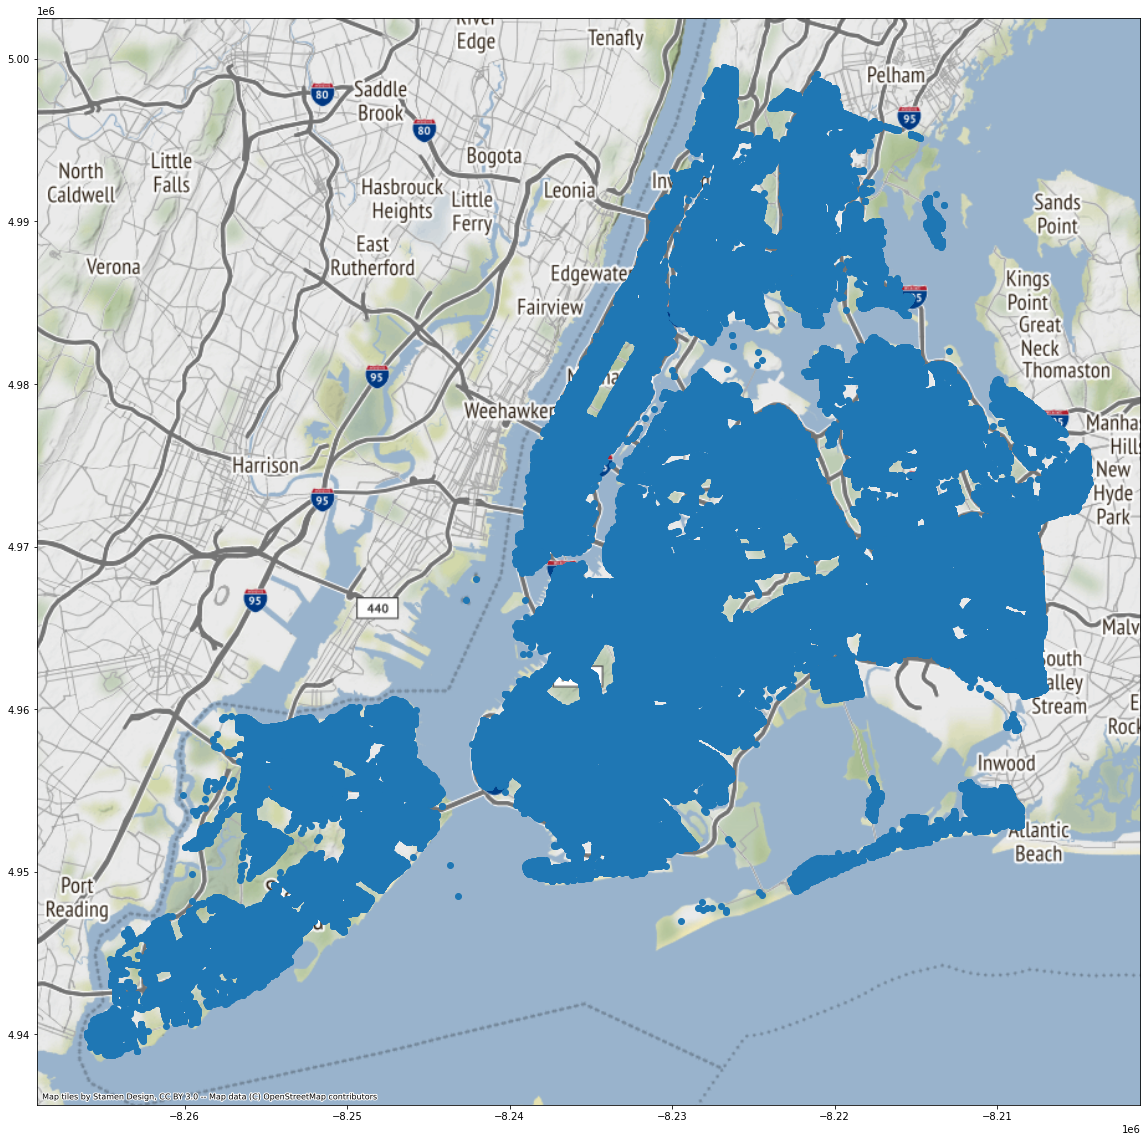

In [25]:
fig, ax = plt.subplots(figsize=(20,20))
value_gdf.to_crs('EPSG:3857').plot(ax=ax)
ctx.add_basemap(ax)

in order to combine the two datasets i made a new column in each that combines the borough, block, and lot numbers (keeping it as a string)

In [17]:
value_gdf['BBB'] = value_gdf['boro'] + '-' + value_gdf['block'] + '-' + value_gdf['lot']
value_gdf['BBB']

0           1-16-3633
1           1-16-3634
2           1-16-3635
3             1-13-27
4           1-16-3666
              ...    
1110053     5-7074-43
1110054     5-7893-10
1110055     5-7890-79
1110056     5-7317-50
1110057    5-7826-224
Name: BBB, Length: 1110058, dtype: object

In [18]:
actions_df['BBB'] = actions_df['borough_code'] + '-' + actions_df['block_number'] + '-' + actions_df['lot_number']
actions_df['BBB']

0            1-7-29
1            1-7-29
2            1-7-30
3            1-7-30
4            1-7-31
            ...    
12316    5-72614-11
12317     5-72616-1
12318     5-72616-1
12319     5-72830-5
12320     5-72830-5
Name: BBB, Length: 12321, dtype: object

next i set the indexes in each to the new BBB identifiers

In [19]:
actions_df.set_index('BBB', inplace=True)
value_gdf.set_index('BBB', inplace=True)

then i joined them using an inner join to just get the results where both datasets had the same BBB

we should probably double check this going forward and see if we missed any properties

In [8]:
joined_gdf = value_gdf.join(actions_df, how='inner', rsuffix=('_actions'))

In [9]:
print('number of properties that overlap between the two datasets is '+str(len(joined_gdf)))
print('actions dataset length is '+str(len(actions_df)))
print('valuation dataset length is '+str(len(value_gdf)))

number of properties that overlap between the two datasets is 12346
actions dataset length is 12321
valuation dataset length is 1110058


In [31]:
#we have more rows in the joined dataset than the assessments dataset, which will need investigated

In [32]:
#checking the columns

In [10]:
joined_gdf.columns

Index(['geometry', 'nta', 'avland', 'latitude', 'zip', 'stories', 'avtot',
       'easement', 'valtype', 'exland', 'blddepth', 'year', 'taxclass',
       'longitude', 'bldfront', 'bldgcl', 'block', 'avtot2', 'excd1', 'bble',
       'staddr', 'exmptcl', 'avland2', 'census_tract', 'lot', 'boro',
       'ltfront', 'fullval', 'ext', 'bin', 'excd2', 'owner', 'extot', 'extot2',
       'exland2', 'community_board', 'borough', 'period', 'council_district',
       'ltdepth', 'borough_code', 'block_number', 'lot_number', 'tax_year',
       'owner_name', 'property_address', 'granted_reduction_amount',
       'tax_class_code'],
      dtype='object')

making a new column of the reduction amount divided by the actual total value of the property

In [11]:
#making them numeric first
joined_gdf['granted_reduction_amount']=pd.to_numeric(joined_gdf['granted_reduction_amount'])
joined_gdf['avtot']=pd.to_numeric(joined_gdf['avtot'])

#making the new column
joined_gdf['reduction_scaled']=joined_gdf['granted_reduction_amount']/joined_gdf['avtot']

plotting the properties that have been granted reductions with marker size based on the scaled reduction amount

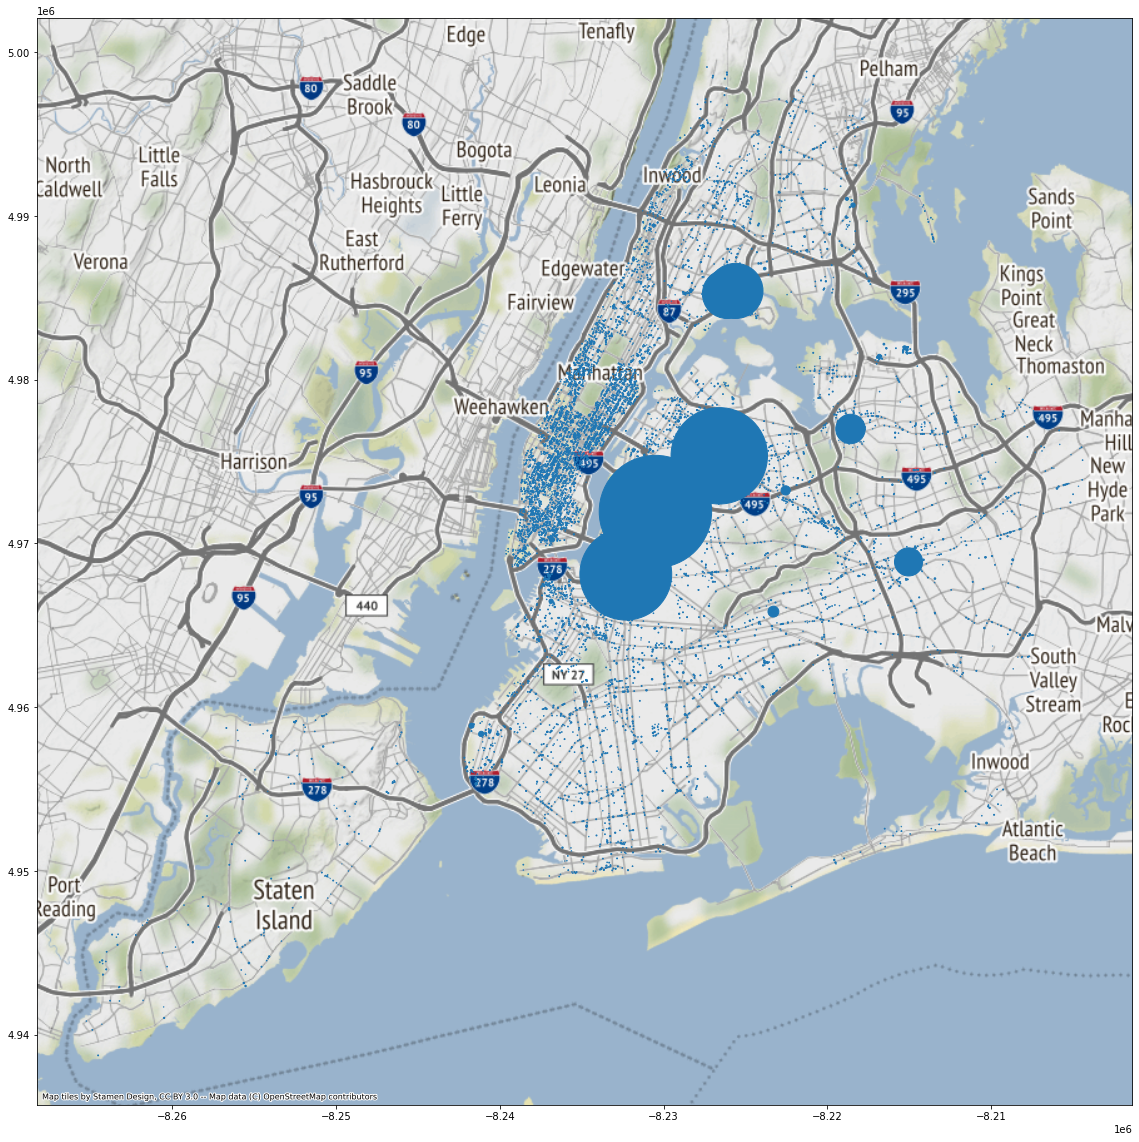

In [40]:
fig, ax = plt.subplots(figsize=(20,20))
joined_gdf.to_crs('EPSG:3857').plot(ax=ax, markersize=joined_gdf['reduction_scaled']*5)
ctx.add_basemap(ax)

**going forward we need:**
- to increase the size of the valuation dataset that we use (by getting an app_token)
- to figure out how to better visualize the reductions in value (some of the values are super different than others and there are going to be a bunch of points). maybe we plot them by borough?
- maybe spatial join to tracts so that we can summarize the data by census tracts

## Census Data ##

In [41]:
#using cenpy to get ACS census tract data

In [42]:
from cenpy import products

#starting with median household income data
incomeDf = products.ACS(2017).from_place('New York City', level='tract',
                                        variables='B19019_001E')
incomeDf.rename(columns={'B19019_001E':'median_HH_income'}, inplace=True)
incomeDf.head()

/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/cenpy/products.py:791: UserWarning: Uncertain place identifier "New York City". The place identifier should look something like "placename, state" or, for larger areas, like Combined Statistical Areas or Metropolitan Statistical Areas,"placename1-placename2, state1-state2-state3"
  geoms, variables, *rest = super(ACS, self).from_place(
/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be min

Matched: New York City to New York city within layer Incorporated Places


/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/xm/hhzqqkqx18z99mv99fltb_vm0000gq/T/ipykernel_2979/4174070631.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  incomeDf = products.ACS

GEOID                                           geometry  \
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...   
2  36085027706  POLYGON ((-8256097.640 4952157.350, -8255857.1...   
3  36085014605  POLYGON ((-8254991.570 4948209.800, -8254909.4...   
4  36085024700  POLYGON ((-8254048.590 4957893.610, -8253996.2...   

   median_HH_income state county   tract  
0           91131.0    36    085  017012  
1           74630.0    36    085  014607  
2           80286.0    36    085  027706  
3          107589.0    36    085  014605  
4           56875.0    36    085  024700

In [43]:
incomeDf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2061 entries, 0 to 2060
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   GEOID             2061 non-null   object  
 1   geometry          2061 non-null   geometry
 2   median_HH_income  2009 non-null   float64 
 3   state             2061 non-null   object  
 4   county            2061 non-null   object  
 5   tract             2061 non-null   object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 112.7+ KB


<AxesSubplot:>

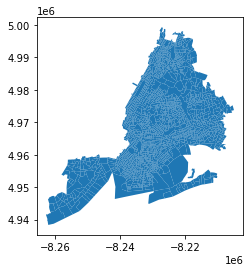

In [44]:
incomeDf.plot()

In [52]:
#using a spatial join to bring the point data for property values and reductions from above into the census tract dataset
sjoindf = incomeDf.sjoin(joined_gdf.to_crs("EPSG:3857"), predicate='intersects')
sjoindf.head()

GEOID                                           geometry  \
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...   
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...   
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...   

   median_HH_income state county   tract index_right  \
0           91131.0    36    085  017012    5-5639-8   
0           91131.0    36    085  017012    5-5609-6   
0           91131.0    36    085  017012   5-5533-58   
1           74630.0    36    085  014607   5-5533-62   
1           74630.0    36    085  014607   5-5533-47   

                                          nta   avland   latitude  ...  \
0  Annadale-Huguenot-Prince's Bay-Eltingville     8359  40.552646  ...   
0  Annadale-Huguenot-Prince's Bay-Eltingville    11250  40.554805  ...   
0                                 Great Kills  2409300    40.5604  ...   
1                                 Great Kills   535500  40.559895  ...   
1                                 Great Kills   313200  40.559931  ...   

  ltdepth borough_code  block_number lot_number tax_year  \
0     105            5          5639          8     2018   
0     100            5          5609          6     2018   
0     705            5          5533         58     2018   
1     240            5          5533         62     2018   
1     125            5          5533         47     2018   

              owner_name       property_address granted_reduction_amount  \
0        BOKTOR, RAFIK E      413 ANNADALE ROAD                     2346   
0  BELAIR RIDGE DEVELOPM    651 LEVERETT AVENUE                    40760   
0  KIMCO GREENRIDGE 674,   3231 RICHMOND AVENUE                  2749260   
1  KIMCO GREENRIDGE 674,   3247 RICHMOND AVENUE                   255100   
1  KIMCO GREENRIDGE 674,  3245Q RICHMOND AVENUE                   383550   

  tax_class_code reduction_scaled  
0              1         0.085086  
0             2B         0.137239  
0              4         0.283173  
1              4         0.197936  
1              4         0.277452  

[5 rows x 55 columns]

In [54]:
#now each point has an associated census tract
sjoindf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 11208 entries, 0 to 2059
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   GEOID                     11208 non-null  object  
 1   geometry                  11208 non-null  geometry
 2   median_HH_income          11097 non-null  float64 
 3   state                     11208 non-null  object  
 4   county                    11208 non-null  object  
 5   tract                     11208 non-null  object  
 6   index_right               11208 non-null  object  
 7   nta                       11208 non-null  object  
 8   avland                    11208 non-null  object  
 9   latitude                  11208 non-null  object  
 10  zip                       11208 non-null  object  
 11  stories                   10963 non-null  object  
 12  avtot                     11208 non-null  int64   
 13  easement                  4 non-null   

In [55]:
#making a new df with the total reduction amount granted per tract
tract_info = sjoindf.groupby('tract')[['granted_reduction_amount']].sum()
tract_info.head()

granted_reduction_amount
tract                           
000100                   4021688
000200                    564360
000201                     99350
000301                   6108482
000501                   4181024

In [56]:
#renaming the column to reflect that it's for the tract as a whole
tract_info.rename(columns={'granted_reduction_amount':'total_tract_reduction'}, inplace=True)

In [57]:
tract_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1056 entries, 000100 to 157902
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   total_tract_reduction  1056 non-null   int64
dtypes: int64(1)
memory usage: 16.5+ KB


In [58]:
#joining the total reduction data back to the census df to be able to plot it by tract
tractjoin = incomeDf.join(tract_info, on='tract')

In [59]:
tractjoin.head()

GEOID                                           geometry  \
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...   
2  36085027706  POLYGON ((-8256097.640 4952157.350, -8255857.1...   
3  36085014605  POLYGON ((-8254991.570 4948209.800, -8254909.4...   
4  36085024700  POLYGON ((-8254048.590 4957893.610, -8253996.2...   

   median_HH_income state county   tract  total_tract_reduction  
0           91131.0    36    085  017012              2792366.0  
1           74630.0    36    085  014607               638650.0  
2           80286.0    36    085  027706               380600.0  
3          107589.0    36    085  014605                    NaN  
4           56875.0    36    085  024700              1522850.0

Text(0.5, 1.0, 'Total Reductions Granted Per Census Tract')

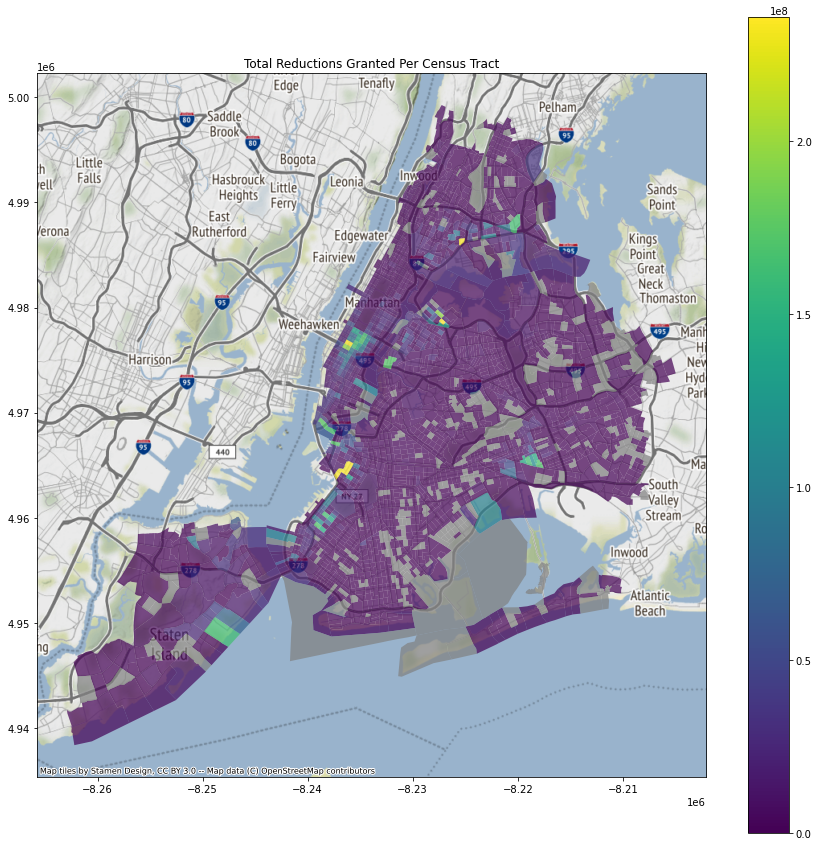

In [60]:
#plotting the total reduction granted per census tract to better visualize the distribution throughout NYC, with NaN values colored in as grey
fig, ax = plt.subplots(figsize=(15,15))
tractjoin.plot(column='total_tract_reduction', ax=ax, missing_kwds= dict(color = "grey"), alpha=.7, legend=True)
ctx.add_basemap(ax)
ax.set_title("Total Reductions Granted Per Census Tract")

Machine Learning Attempt

To begin, I wanted to create a column that tells us whether a property from the assesment dataset got a reduction or not. So I created a join, while removing duplicates, that would left join the actions to the valuations.

In [21]:
actions_df.index.is_unique
value_gdf.index.is_unique

False

In [22]:
#creating two new datasets just without duplicates

print('Before dropping duplicates: {}'.format(len(actions_df)))
actions_nodupl = actions_df.groupby('BBB').first()
print('After dropping duplicates: {}'.format(len(actions_nodupl)))
actions_nodupl.index.is_unique

#same thing with the other
print('Before dropping duplicates: {}'.format(len(value_gdf)))
value_nodupl = value_gdf.groupby('BBB').first()
print('After dropping duplicates: {}'.format(len(value_nodupl)))
value_nodupl.index.is_unique

Before dropping duplicates: 12321
After dropping duplicates: 10062
Before dropping duplicates: 1110058
After dropping duplicates: 1105748


True

In [24]:
# the join

NewDf_for_ML = value_nodupl.join(actions_nodupl, how='left')
print('Number of valuations: {}'.format(len(NewDf_for_ML)))
print('Number of reductions: {}'.format(NewDf_for_ML['granted_reduction_amount'].count()))

#Almost all of the reductions got added so i think this is fine

Number of valuations: 1105748
Number of reductions: 10004


In [25]:
NewDf_for_ML.granted_reduction_amount.fillna(0,inplace=True)
NewDf_for_ML['granted_reduction_amount'] = NewDf_for_ML['granted_reduction_amount'].astype(float)
NewDf_for_ML['got_reduction'] = NewDf_for_ML['granted_reduction_amount'] > 0
NewDf_for_ML.head()

geometry                          nta     avland  \
BBB                                                                           
1-1-10   POINT (-74.01287 40.69010)  park-cemetery-etc-Manhattan  104445450   
1-1-101  POINT (-74.04534 40.68989)  park-cemetery-etc-Manhattan    4225950   
1-1-201  POINT (-74.03975 40.69883)  park-cemetery-etc-Manhattan   14972400   
1-1-301                        None                         None          0   
1-1-401                        None                         None          0   

          latitude    zip stories      avtot easement valtype     exland  ...  \
BBB                                                                       ...   
1-1-10   40.690096  10004    None  161206200     None   AC-TR  104445450  ...   
1-1-101  40.689887  10004    None   12873150     None   AC-TR    4225950  ...   
1-1-201  40.698831  10004    None  111703950     None   AC-TR   14972400  ...   
1-1-301       None   None    None          0     None   AC-TR          0  ...   
1-1-401       None   None    None          0     None   AC-TR          0  ...   

        ltdepth borough_code block_number lot_number tax_year owner_name  \
BBB                                                                        
1-1-10        0          NaN          NaN        NaN      NaN        NaN   
1-1-101    1046          NaN          NaN        NaN      NaN        NaN   
1-1-201       0          NaN          NaN        NaN      NaN        NaN   
1-1-301       0          NaN          NaN        NaN      NaN        NaN   
1-1-401       0          NaN          NaN        NaN      NaN        NaN   

        property_address granted_reduction_amount tax_class_code got_reduction  
BBB                                                                             
1-1-10               NaN                      0.0            NaN         False  
1-1-101              NaN                      0.0            NaN         False  
1-1-201              NaN                      0.0            NaN         False  
1-1-301              NaN                      0.0            NaN         False  
1-1-401              NaN                      0.0            NaN         False  

[5 rows x 49 columns]

In [26]:
NewDf_for_ML.columns

Index(['geometry', 'nta', 'avland', 'latitude', 'zip', 'stories', 'avtot',
       'easement', 'valtype', 'exland', 'blddepth', 'year', 'taxclass',
       'longitude', 'bldfront', 'bldgcl', 'block', 'avtot2', 'excd1', 'bble',
       'staddr', 'exmptcl', 'avland2', 'census_tract', 'lot', 'boro',
       'ltfront', 'fullval', 'ext', 'bin', 'excd2', 'owner', 'extot', 'extot2',
       'exland2', 'community_board', 'borough', 'period', 'council_district',
       'ltdepth', 'borough_code', 'block_number', 'lot_number', 'tax_year',
       'owner_name', 'property_address', 'granted_reduction_amount',
       'tax_class_code', 'got_reduction'],
      dtype='object')

In [27]:
from sklearn.model_selection import train_test_split

#we can put more interesting variables as we sort them out, but for now i used these 3

xvars = ['avtot','avland', 'stories']

yvar = 'got_reduction'

df_to_fit = NewDf_for_ML[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

790188 790188
263397 263397


In [28]:
from sklearn.ensemble import RandomForestClassifier # note there is also a RandomForestRegressor

# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

array([False, False, False, ..., False, False, False])

In [29]:
print(len(X_test), len(y_pred))

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

263397 263397
[[260692    349]
 [  2254    102]]


<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

Text(0, 0.5, 'Mean decrease in impurity')

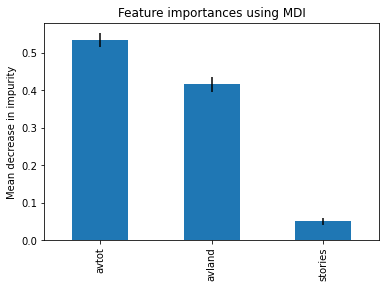

In [30]:
import numpy as np
importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# plot importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")